In [1]:
# Import required libraries
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
#from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pathlib import Path
import nltk
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import requests
import json
import time

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Sagemaker
import os
import boto3  # AWS Python sdk
import io
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
bucket = 'project2inthenews' #'<your_s3_bucket_name_here>'

In [3]:
# Define prefix for data files
prefix = "alpaca"

# AWS IAM role
role = get_execution_role()

In [4]:
# Install Alpaca, New API, PRAW (Reddit)
!pip3 install alpaca-trade-api
import alpaca_trade_api as tradeapi

!pip3 install newsapi-python
from newsapi import NewsApiClient

!pip3 install praw
import praw

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key='d54f9f8f49c4408b8e0bc34d0f853764')

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [6]:
# Set the ticker
ticker = input()

# Set timeframe to '1D'
timeframe = "1D"

# Set current date and the date from the last "n" days using the ISO format. 
current_date = pd.Timestamp(datetime.now(), tz="America/New_York").isoformat()
past_date = pd.Timestamp(datetime.now()- timedelta(360), tz="America/New_York").isoformat()

# Get 4 weeks worth of historical data for the input ticker
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=past_date,
    end=current_date,
    after=None,
    until=None,
).df

# Display data
df.head()

 FB


FB                                    
                             open      high     low   close    volume
time                                                                 
2021-07-15 00:00:00-04:00  349.38  349.5500  340.22  344.55  13567006
2021-07-16 00:00:00-04:00  344.83  345.9899  340.14  341.16   9853219
2021-07-19 00:00:00-04:00  337.74  339.7900  334.54  337.00  12418470
2021-07-20 00:00:00-04:00  338.15  343.4500  334.50  341.64   9306649
2021-07-21 00:00:00-04:00  341.71  346.5200  341.25  346.23   7788720

In [7]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Remove time component from index
df.index = df.index.date

# Display sample data
df.head()

,open,high,low,close,volume
2021-07-15,349.38,349.5500,340.22,344.55,13567006
2021-07-16,344.83,345.9899,340.14,341.16,9853219
2021-07-19,337.74,339.7900,334.54,337.00,12418470
2021-07-20,338.15,343.4500,334.50,341.64,9306649
2021-07-21,341.71,346.5200,341.25,346.23,7788720


In [8]:
# Calculated percentage change in returns
df['pct_change'] = df['close'].pct_change()

# Display sample data
df.dropna(inplace=True)

# Recast index as datetime type
df.index = pd.to_datetime(df.index)
df.head()

,open,high,low,close,volume,pct_change
2021-07-16,344.83,345.9899,340.14,341.16,9853219,-0.009839
2021-07-19,337.74,339.7900,334.54,337.00,12418470,-0.012194
2021-07-20,338.15,343.4500,334.50,341.64,9306649,0.013769
2021-07-21,341.71,346.5200,341.25,346.23,7788720,0.013435
2021-07-22,346.60,351.5400,345.21,351.19,10364322,0.014326


In [9]:
# DF status
df.describe()

,open,high,low,close,volume,pct_change
count,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.000000
mean,348.207929,351.902453,344.096743,347.903831,1.673884e+07,-0.001004
std,18.420881,18.238803,19.179303,19.218940,9.655155e+06,0.018313
min,311.400000,313.750000,299.500000,306.820000,6.150093e+06,-0.050560
25%,334.505000,336.606500,328.845000,333.580000,1.016316e+07,-0.011110
50%,344.540000,349.670000,340.690100,343.090000,1.346610e+07,0.000305
75%,362.450000,365.605000,358.961750,363.235000,2.098123e+07,0.011710
max,381.770000,384.330000,378.810000,382.110000,6.241350e+07,0.052963


In [10]:
# Function that outputs daily news articles from NewsAPI for 30 days
# Input is keyword to search news
# Outputs a list of articles and the associated dates

past_date_news = pd.Timestamp(datetime.now()- timedelta(30), tz="America/New_York").isoformat()


def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date_news[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language="en",
            sort_by="relevancy",
            page=1,
        )
        headlines = []
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    return all_headlines, all_dates

In [11]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [12]:
# Get articles from NewsAPI
keyword=input()
all_headlines, dates = get_headlines(keyword)

 facebook


Fetching news about 'facebook'
******************************
retrieving news from: 2021-12-05 00:00:00
retrieving news from: 2021-12-04 00:00:00
retrieving news from: 2021-12-03 00:00:00
retrieving news from: 2021-12-02 00:00:00
retrieving news from: 2021-12-01 00:00:00
retrieving news from: 2021-11-30 00:00:00
retrieving news from: 2021-11-29 00:00:00
retrieving news from: 2021-11-28 00:00:00
retrieving news from: 2021-11-27 00:00:00
retrieving news from: 2021-11-26 00:00:00
retrieving news from: 2021-11-25 00:00:00
retrieving news from: 2021-11-24 00:00:00
retrieving news from: 2021-11-23 00:00:00
retrieving news from: 2021-11-22 00:00:00
retrieving news from: 2021-11-21 00:00:00
retrieving news from: 2021-11-20 00:00:00
retrieving news from: 2021-11-19 00:00:00
retrieving news from: 2021-11-18 00:00:00
retrieving news from: 2021-11-17 00:00:00
retrieving news from: 2021-11-16 00:00:00
retrieving news from: 2021-11-15 00:00:00
retrieving news from: 2021-11-14 00:00:00
retrieving new

In [13]:
# Create news article dataframe
articles_dictionary = {'date': dates , 'all_headlines': all_headlines}
articles_df = pd.DataFrame(articles_dictionary)

# Initiatlise Vader sentiment analyser 
vader = SentimentIntensityAnalyzer()

# Adding extra df to change listed outputs into strings
articles_df['text_as_string'] = articles_df["all_headlines"].str[0].str.join("")
articles_df['text_as_string'].apply(lambda x: vader.polarity_scores(x)['compound'])
articles_df

,date,all_headlines,text_as_string
0,2021-12-05,[Facebook Messenger is getting a new bill spli...,Facebook Messenger is getting a new bill split...
1,2021-12-04,"[How to Find the Admin of a Facebook Page, Mes...",How to Find the Admin of a Facebook Page
2,2021-12-03,[Facebook allowed ads that promoted anti-vacci...,Facebook allowed ads that promoted anti-vaccin...
3,2021-12-02,[Facebook Will Force More At-Risk Accounts to ...,Facebook Will Force More At-Risk Accounts to U...
4,2021-12-01,[Facebook details its takedown of a mass-haras...,Facebook details its takedown of a mass-harass...
5,2021-11-30,"[Facebook, Tesla, Regeneron Pharma, ImmunoGen ...","Facebook, Tesla, Regeneron Pharma, ImmunoGen -..."
6,2021-11-29,[Frances Haugen Still Thinks People Should Wor...,Frances Haugen Still Thinks People Should Work...
7,2021-11-28,[Australia plans laws to make social networks ...,Australia plans laws to make social networks i...
8,2021-11-27,[Dominique Morisseau Pulls Play From L.A. Thea...,Dominique Morisseau Pulls Play From L.A. Theat...
9,2021-11-26,[Facebook offers remedies to address EU concer...,Facebook offers remedies to address EU concern...


In [14]:
analyzer = SentimentIntensityAnalyzer()

# Generating sentiment scores and putting them into the dataframe
articles_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in articles_df['text_as_string']]
articles_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in articles_df['text_as_string']]
articles_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in articles_df['text_as_string']]
articles_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in articles_df['text_as_string']]
refined_df = articles_df.drop(columns=('all_headlines')).set_index('date')

In [15]:
# Create combined dataframe for newsap and alpaca data
all_df = pd.concat([refined_df, df], axis=1)
all_df.dropna(inplace=True)
all_df

,text_as_string,compound,neg,neu,pos,open,high,low,close,volume,pct_change
2021-11-08,‘AR Is Where the Real Metaverse Is Going to Ha...,0.0000,0.000,1.000,0.000,344.38,344.7890,338.340,338.53,15333904.0,-0.007622
2021-11-09,EXCLUSIVE Facebook unblocks '#saltbae' hashtag...,0.3034,0.000,0.817,0.183,339.86,341.3075,334.470,335.40,15537602.0,-0.009246
2021-11-10,Three Out of Four Adults Think Facebook Is Mak...,-0.4767,0.205,0.795,0.000,332.66,333.1900,325.510,327.65,19579487.0,-0.023107
2021-11-11,This is how NVIDIA wants to go beyond the meta...,0.0000,0.000,1.000,0.000,329.55,332.4590,327.000,327.75,11585353.0,0.000305
2021-11-12,Engadget Podcast: A $249 Surface Laptop and Bl...,0.0000,0.000,1.000,0.000,330.18,341.8600,329.780,340.90,22387985.0,0.040122
2021-11-15,"Ohio's Largest Public Pension Sues Facebook, S...",0.0000,0.000,1.000,0.000,344.54,353.6500,343.200,347.61,22989954.0,0.019683
2021-11-16,Meta goes into lockdown,0.0000,0.000,1.000,0.000,343.77,346.6500,340.870,342.93,16168589.0,-0.013463
2021-11-17,News Corp Chairman Rupert Murdoch takes swings...,0.0000,0.000,1.000,0.000,344.23,347.3000,340.100,340.81,11774448.0,-0.006182
2021-11-18,Facebook test offers more control over who you...,0.0000,0.000,1.000,0.000,339.61,342.4600,335.300,338.69,15735243.0,-0.006220
2021-11-19,Facebook tells LA police to stop spying on use...,-0.6486,0.346,0.654,0.000,342.35,352.1000,339.900,345.31,24105070.0,0.019546


In [16]:
# Set up model for Newsapi data
model_df = all_df.drop(columns=["neg","neu","pos","text_as_string","open", "high", "low"])
train = model_df[:int(model_df.shape[0]*0.7)]
test =  model_df[int(model_df.shape[0]*0.7):]

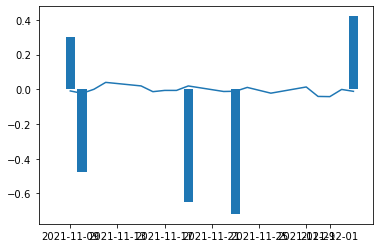

In [17]:
# Plot the compound score and percent change
barchart = plt.bar(model_df.index, model_df.compound) 
linechart = plt.plot(model_df.index, model_df.close.pct_change())

In [18]:
test

,compound,close,volume,pct_change
2021-11-26,0.0000,333.47,10684602.0,-0.022111
2021-11-29,0.0000,338.02,14319199.0,0.013644
2021-11-30,0.0000,324.19,20462734.0,-0.040915
2021-12-01,0.0000,310.57,26952026.0,-0.042012
2021-12-02,0.0000,310.38,21838560.0,-0.000612
2021-12-03,0.4215,306.82,24794411.0,-0.011470


In [19]:
# Set up train and test data
X_train = train.drop(columns=["close", 'pct_change'])
y_train = train["pct_change"]
X_test = test.drop(columns=["close", 'pct_change'])
y_test = test["pct_change"]

In [20]:
X_test

,compound,volume
2021-11-26,0.0000,10684602.0
2021-11-29,0.0000,14319199.0
2021-11-30,0.0000,20462734.0
2021-12-01,0.0000,26952026.0
2021-12-02,0.0000,21838560.0
2021-12-03,0.4215,24794411.0


In [21]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

R2 score: -1.922431286411638
Out-of-Sample Root Mean Squared Error (RMSE): 0.03462573408200262


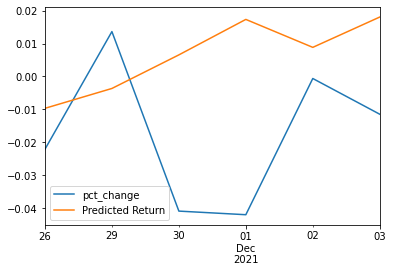

In [22]:
# Predictions and statistical analysis of model. Note the limited data set.
predictions = model.predict(X_test)
results = y_test.to_frame()
results["Predicted Return"] = predictions
results.plot()
mse = mean_squared_error(results["pct_change"], results["Predicted Return"])
rmse = np.sqrt(mse)
r2 = r2_score(results['pct_change'], results['Predicted Return'])
print(f"R2 score: {r2}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

In [23]:
# Display results
results

,pct_change,Predicted Return
2021-11-26,-0.022111,-0.009677
2021-11-29,0.013644,-0.003639
2021-11-30,-0.040915,0.006568
2021-12-01,-0.042012,0.017349
2021-12-02,-0.000612,0.008853
2021-12-03,-0.011470,0.018068


In [24]:
## REDDIT. This section contains the code to obtain data from Reddit using Reddit PRAW API.

In [25]:
# API keys
CLIENT_ID = 'MnLMKnyq3_YI43rKVp3_Gw'
SECRET_KEY = 'Bpvh_flU8yAJE4PdUo2Wj-S6uQx6xw'

In [26]:
# Logging into Reddit through API credentials
reddit = praw.Reddit(client_id = 'MnLMKnyq3_YI43rKVp3_Gw', 
                     client_secret = 'Bpvh_flU8yAJE4PdUo2Wj-S6uQx6xw',
                     username='MyPCIsAPotato123',
                     password='7898527412369',
                     user_agent='tutorialv1')

In [27]:
# Selecting Sub-Reddit to pull the data from
subreddit = reddit.subreddit('wallstreetbets')

In [28]:
# Reformating date input because Reddit API required 'YYYY-MM-DD'
current_date_reddit = current_date[:10]
past_date_reddit = past_date[:10]
print(current_date_reddit, past_date_reddit)

2021-12-05 2020-12-10


In [29]:
# Creating empty df to store reddit API data
reddit_df = pd.DataFrame()

# Search through subreddit for ticker, default limit for free Reddit account is 250 posts
# Then append results into dataframe
for submission in subreddit.search(ticker, limit=250):
    reddit_df = reddit_df.append({'time': submission.created_utc,
                                  'title': submission.title,
                                  'body': submission.selftext}, ignore_index=True)
    
reddit_df.head()

,body,time,title
0,**Historical Post Earnings Moves MEGA Compilat...,1.635116e+09,Historical Post Earnings Moves MEGA Compilatio...
1,,1.634910e+09,FB Yolo $7500
2,,1.633366e+09,Whistle-blower article seemed to precipitate t...
3,,1.635192e+09,F FB
4,,1.637510e+09,+295% in 3 weeks on FB calls. Not bad


In [30]:
print(reddit_df['time'])

0      1.635116e+09
1      1.634910e+09
2      1.633366e+09
3      1.635192e+09
4      1.637510e+09
           ...     
241    1.615094e+09
242    1.616167e+09
243    1.578592e+09
244    1.521683e+09
245    1.612235e+09
Name: time, Length: 246, dtype: float64


In [31]:
# Returned time data is in unix format by default, change to standard format YYY-MM-DD HH:MM:SS
reddit_df['time'] = reddit_df['time'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
print(reddit_df['time'])

0      2021-10-24
1      2021-10-22
2      2021-10-04
3      2021-10-25
4      2021-11-21
          ...    
241    2021-03-07
242    2021-03-19
243    2020-01-09
244    2018-03-22
245    2021-02-02
Name: time, Length: 246, dtype: object


In [32]:
# Re-organise columns to make it easier to read
reddit_df = reddit_df[['time', 'title', 'body']]
reddit_df

,time,title,body
0,2021-10-24,Historical Post Earnings Moves MEGA Compilatio...,**Historical Post Earnings Moves MEGA Compilat...
1,2021-10-22,FB Yolo $7500,
2,2021-10-04,Whistle-blower article seemed to precipitate t...,
3,2021-10-25,F FB,
4,2021-11-21,+295% in 3 weeks on FB calls. Not bad,
...,...,...,...
241,2021-03-07,What GME has become,"GME by now has become a symbol of ""power to th..."
242,2021-03-19,🐳 🪓 Whales to Watch 3/22: ROCKET REVENGE TOUR ...,🚨 CORRESPONDENTS NEEDED 🚨 \n\nAmidst the spraw...
243,2020-01-09,Who the fuck is playing FB earnings,Earnings report on 1/30 obviously going to be ...
244,2018-03-22,🚀🚀 $FB TO MOON 🚀🚀,


In [33]:
# Sort df with respect to time
reddit_df = reddit_df.sort_values(by='time', ascending=False).reset_index(drop=True)
reddit_df

,time,title,body
0,2021-12-03,"🔝 Don $BB 🔝 - Blackberry, The Holiday Gift For...",On the last earnings call 9/22 CEO Johnny Rock...
1,2021-11-24,Hit me $BB 🍇 one more time! (Papa Chen about t...,"Hi Everyone,\n\nBlackBerry is set to have a pa..."
2,2021-11-22,"$MU Micron Technology, deep-dive Adderall-fuel...","Part 2: [$MU (Micron Technologies) DD (part 2,..."
3,2021-11-21,+295% in 3 weeks on FB calls. Not bad,
4,2021-11-19,Industry incumbents influence on the social me...,I recently started investing in the market and...
...,...,...,...
241,2018-07-25,FB Earnings thread (keep all discussion here; ...,**EPS Estimate** $1.72\n\n**Revenue Estimate**...
242,2018-05-21,A little something for my homies who bought th...,
243,2018-03-23,Musk says Short FB!,
244,2018-03-22,🚀🚀 $FB TO MOON 🚀🚀,


In [34]:
# Initialize vader sentiment model- check maybe duplicate
analyzer = SentimentIntensityAnalyzer()

In [35]:
# Preparing model, apply VADER sentiment, calculate sentiment scores, then append results
title = {
    "compound": [],
    "pos": [],
    "neu": [],
    "neg": [],
}

for index, row in reddit_df.iterrows():
    try:
        title_sentiment = analyzer.polarity_scores(row['title'])
        title['compound'].append(title_sentiment['compound'])
        title['pos'].append(title_sentiment['pos'])
        title['neu'].append(title_sentiment['neu'])
        title['neg'].append(title_sentiment['neg'])
        
    except AtributeError:
        pass

In [36]:
# Reformat VADER results into a dataframe
title_sentiment_df = pd.DataFrame(title)

# Join VADER results df with the original reddit df 
combined_df = reddit_df.join(title_sentiment_df)

# Ensure the data type of 'time' column is set to datetime

combined_df['time'] = pd.to_datetime(combined_df['time'])
combined_df.head()

,time,title,body,compound,pos,neu,neg
0,2021-12-03,"🔝 Don $BB 🔝 - Blackberry, The Holiday Gift For...",On the last earnings call 9/22 CEO Johnny Rock...,0.6808,0.444,0.556,0.0
1,2021-11-24,Hit me $BB 🍇 one more time! (Papa Chen about t...,"Hi Everyone,\n\nBlackBerry is set to have a pa...",0.2481,0.087,0.913,0.0
2,2021-11-22,"$MU Micron Technology, deep-dive Adderall-fuel...","Part 2: [$MU (Micron Technologies) DD (part 2,...",0.0000,0.000,1.000,0.0
3,2021-11-21,+295% in 3 weeks on FB calls. Not bad,,0.4310,0.289,0.711,0.0
4,2021-11-19,Industry incumbents influence on the social me...,I recently started investing in the market and...,0.0000,0.000,1.000,0.0


In [37]:
# combined dataframe
combined_df = combined_df.set_index('time')
combined_df

,title,body,compound,pos,neu,neg
time,,,,,,
2021-12-03,"🔝 Don $BB 🔝 - Blackberry, The Holiday Gift For...",On the last earnings call 9/22 CEO Johnny Rock...,0.6808,0.444,0.556,0.000
2021-11-24,Hit me $BB 🍇 one more time! (Papa Chen about t...,"Hi Everyone,\n\nBlackBerry is set to have a pa...",0.2481,0.087,0.913,0.000
2021-11-22,"$MU Micron Technology, deep-dive Adderall-fuel...","Part 2: [$MU (Micron Technologies) DD (part 2,...",0.0000,0.000,1.000,0.000
2021-11-21,+295% in 3 weeks on FB calls. Not bad,,0.4310,0.289,0.711,0.000
2021-11-19,Industry incumbents influence on the social me...,I recently started investing in the market and...,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...
2018-07-25,FB Earnings thread (keep all discussion here; ...,**EPS Estimate** $1.72\n\n**Revenue Estimate**...,0.0000,0.000,1.000,0.000
2018-05-21,A little something for my homies who bought th...,,-0.4404,0.000,0.791,0.209
2018-03-23,Musk says Short FB!,,0.0000,0.000,1.000,0.000


In [38]:
# Averaging the scores within a day if there are multiple posts within a day
daily_compound_df = pd.DataFrame(combined_df.compound.resample('D').mean())

# Dropna then sort index 
daily_compound_df = daily_compound_df.dropna().sort_index(ascending=False)
daily_compound_df

,compound
time,
2021-12-03,0.6808
2021-11-24,0.2481
2021-11-22,0.0000
2021-11-21,0.4310
2021-11-19,0.0000
...,...
2018-07-25,0.0000
2018-05-21,-0.4404
2018-03-23,0.0000


In [39]:
# Ensure the period analysed matched with what stated initally
period_compound_df = daily_compound_df
period_compound_df

,compound
time,
2021-12-03,0.6808
2021-11-24,0.2481
2021-11-22,0.0000
2021-11-21,0.4310
2021-11-19,0.0000
...,...
2018-07-25,0.0000
2018-05-21,-0.4404
2018-03-23,0.0000


In [40]:
# Combined Reddit and Alpaca dataframes
red_df = pd.concat([period_compound_df, df],axis=1)

In [76]:
red_df.tail(20)

,compound,open,high,low,close,volume,pct_change
2021-11-09,0.00000,339.86,341.3075,334.470,335.40,15537602.0,-0.009246
2021-11-10,NaN,332.66,333.1900,325.510,327.65,19579487.0,-0.023107
2021-11-11,NaN,329.55,332.4590,327.000,327.75,11585353.0,0.000305
2021-11-12,NaN,330.18,341.8600,329.780,340.90,22387985.0,0.040122
2021-11-13,0.42955,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-15,0.56090,344.54,353.6500,343.200,347.61,22989954.0,0.019683
2021-11-16,NaN,343.77,346.6500,340.870,342.93,16168589.0,-0.013463
2021-11-17,0.00000,344.23,347.3000,340.100,340.81,11774448.0,-0.006182
2021-11-18,NaN,339.61,342.4600,335.300,338.69,15735243.0,-0.006220
2021-11-19,0.00000,342.35,352.1000,339.900,345.31,24105070.0,0.019546


In [42]:
## Twitter. This section contains the code to obtain data from Reddit using Twitter API.

In [43]:
# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = "AAAAAAAAAAAAAAAAAAAAAIRkWAEAAAAAbPORFUD3DCXV0sIL6MZarntBzvo%3D9T3lMXfMxlENqNpZ45j4xdqTgCC9c6BjZ7CdC3K2VZglNRK9Nv"

search_url = "https://api.twitter.com/2/tweets/search/recent"

now = datetime.now()
notnow = now - timedelta(days=1)

In [44]:
# Define function to get tweets
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [60]:
print(ticker)

FB


In [61]:
# Get tweets
now = datetime.utcnow()
now = now - timedelta(minutes=1)
json_responses = []
for i in range(0, 7):
    day = now - timedelta(days=i)
    print(day.isoformat())
    query_params = {'query': f"#{ticker}",
                    'tweet.fields': 'created_at,lang',
                    'max_results': 100,
                    'end_time': day.isoformat() + 'Z'
                    }
    json_responses.append(connect_to_endpoint(search_url, query_params))
    time.sleep(1)

2021-12-05T04:19:22.240757
200
2021-12-04T04:19:22.240757
200
2021-12-03T04:19:22.240757
200
2021-12-02T04:19:22.240757
200
2021-12-01T04:19:22.240757
200
2021-11-30T04:19:22.240757
200
2021-11-29T04:19:22.240757
200


In [62]:
# Set up blank list
texts = []

In [63]:
# Create dataframe for Twitter tweets
dates_formatted = []
for i, response in enumerate(json_responses):
    data = response["data"]
    for j in range(0, len(data)):
        if data[j]["lang"] == 'en':
            #formatted_dates.append(((pd.to_datetime(data[j]["created_at"], infer_datetime_format=True) - timedelta(hours=5)).strftime("%Y-%m-%d"))
            dates_formatted.append((pd.to_datetime(data[j]["created_at"], infer_datetime_format=True) - timedelta(hours=5)))
            
            texts.append(data[j]["text"])

twitter_df = pd.DataFrame({"Date": dates_formatted,
                  "Text": texts})

twitter_df

,Date,Text
0,2021-12-04 23:18:33+00:00,RT @KatanningPol: Don’t ride off road bikes th...
1,2021-12-04 23:09:04+00:00,NWS Fcst: Tonight: Mostly Cloudy then Slight ...
2,2021-12-04 23:08:07+00:00,RT @drmikemurdock: THE UNTHANKFUL…\n\n …IN YO...
3,2021-12-04 23:08:06+00:00,Don’t ride off road bikes through town or on a...
4,2021-12-04 23:05:21+00:00,Starbucks Headquarters in Seattle.\n\n#fb http...
...,...,...
223,2021-11-28 22:02:01+00:00,10:00pm 31°F overcast - light snow; mist (Hi3...
224,2021-11-28 21:59:10+00:00,$CELH Celsius looking for support after hard s...
225,2021-11-28 21:58:55+00:00,RT @lilybean2021: @mem_reddog @and_ragged @Bou...
226,2021-11-28 21:55:25+00:00,HumanProgress: What can reveal the healthiest ...


In [65]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [66]:
# Calculate Twitter sentiment scores
analyzer = SentimentIntensityAnalyzer()
twitter_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in twitter_df['Text']]
twitter_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in twitter_df['Text']]
twitter_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in twitter_df['Text']]
twitter_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in twitter_df['Text']]
twitter_df.sample(100)

,Date,Text,compound,neg,neu,pos
123,2021-12-01 20:15:02+00:00,NWS fcst: TonightMstly Cloudythen ChcWintry Mi...,0.0000,0.000,1.000,0.000
137,2021-11-30 22:54:03+00:00,@PerenjoriPol &amp; @MorawaPol teamed up to vi...,0.7678,0.000,0.824,0.176
140,2021-11-30 22:45:22+00:00,Bruh come man !?😂 #stalekracker #puppet #puppe...,0.0000,0.000,1.000,0.000
25,2021-12-03 22:53:25+00:00,Today Special ✨\nToffee Sticky Pudding Cake\n#...,0.4019,0.000,0.895,0.105
93,2021-12-01 23:09:40+00:00,Share of #teens using ⁦@facebookapp⁩ in #2012 ...,0.3919,0.000,0.914,0.086
...,...,...,...,...,...,...
159,2021-11-30 21:10:25+00:00,@TE_Official_In @ishankishan51 @india4contests...,0.0000,0.000,1.000,0.000
164,2021-11-29 23:19:01+00:00,RT @GeraldtonPol: Geraldton Police would like ...,0.3612,0.000,0.889,0.111
146,2021-11-30 22:27:16+00:00,RT @tulipan81: Opentimestamps nodes in Node-RE...,-0.2942,0.171,0.715,0.114
132,2021-11-30 23:02:02+00:00,11:00pm 33°F overcast - light snow; mist (Hi3...,0.0000,0.000,1.000,0.000


In [67]:
# Combine TWitter sentiment score with stock volume and pct_change
twitter_df.index = pd.to_datetime(twitter_df.index)
twitter_df = pd.DataFrame(twitter_df.groupby(twitter_df.index).mean())
twitter_df.head()
red_df
red_df = red_df["2021-July-15":]
red_df.fillna(0)

,compound,open,high,low,close,volume,pct_change
2021-07-16,0.0000,344.83,345.9899,340.140,341.16,9853219.0,-0.009839
2021-07-17,-0.2553,0.00,0.0000,0.000,0.00,0.0,0.000000
2021-07-19,0.0000,337.74,339.7900,334.540,337.00,12418470.0,-0.012194
2021-07-20,0.0000,338.15,343.4500,334.500,341.64,9306649.0,0.013769
2021-07-21,0.0000,341.71,346.5200,341.250,346.23,7788720.0,0.013435
...,...,...,...,...,...,...,...
2021-11-29,0.0000,336.87,340.6700,335.305,338.02,14319199.0,0.013644
2021-11-30,0.0000,335.00,335.8100,323.430,324.19,20462734.0,-0.040915
2021-12-01,0.0000,330.24,330.5000,310.290,310.57,26952026.0,-0.042012
2021-12-02,0.0000,311.40,314.6000,307.200,310.38,21838560.0,-0.000612


In [68]:
# Create combined sentiment dataframe
tw_df = pd.DataFrame({"Twitter compound": twitter_df["compound"]})
newsAPI_df = pd.DataFrame({"NewsAPI compound": all_df["compound"]})
reddit_df = pd.DataFrame({"Reddit compound": red_df["compound"]})
reddit_df = reddit_df.fillna(0)

newsAPI_df
compounds_df = pd.concat([tw_df, reddit_df, newsAPI_df],axis=1)
# compounds_df.index = pd.to_datetime(compounds_df.index)
compounds_df = compounds_df.fillna(0)
compounds_df["average"] = (compounds_df["Twitter compound"] + compounds_df["Reddit compound"] + compounds_df["NewsAPI compound"]) / 3
compounds_df

,Twitter compound,Reddit compound,NewsAPI compound,average
1970-01-01 00:00:00.000000000,0.0000,0.0000,0.0000,0.000000
1970-01-01 00:00:00.000000001,0.7184,0.0000,0.0000,0.239467
1970-01-01 00:00:00.000000002,-0.7058,0.0000,0.0000,-0.235267
1970-01-01 00:00:00.000000003,0.2732,0.0000,0.0000,0.091067
1970-01-01 00:00:00.000000004,0.0000,0.0000,0.0000,0.000000
...,...,...,...,...
2021-11-29 00:00:00.000000000,0.0000,0.0000,0.0000,0.000000
2021-11-30 00:00:00.000000000,0.0000,0.0000,0.0000,0.000000
2021-12-01 00:00:00.000000000,0.0000,0.0000,0.0000,0.000000
2021-12-02 00:00:00.000000000,0.0000,0.0000,0.0000,0.000000


In [69]:
# Get pct_change into combined sentiment dataframe
compounds_df["pct_change"] = df["pct_change"]
compounds_df["volume"] = df["volume"]
compounds_df.sort_index()
compounds_df.dropna(inplace=True)

In [70]:
compounds_df

,Twitter compound,Reddit compound,NewsAPI compound,average,pct_change,volume
2021-07-16,0.0,0.0000,0.0000,0.000000,-0.009839,9853219.0
2021-07-19,0.0,0.0000,0.0000,0.000000,-0.012194,12418470.0
2021-07-20,0.0,0.0000,0.0000,0.000000,0.013769,9306649.0
2021-07-21,0.0,0.0000,0.0000,0.000000,0.013435,7788720.0
2021-07-22,0.0,0.0000,0.0000,0.000000,0.014326,10364322.0
...,...,...,...,...,...,...
2021-11-29,0.0,0.0000,0.0000,0.000000,0.013644,14319199.0
2021-11-30,0.0,0.0000,0.0000,0.000000,-0.040915,20462734.0
2021-12-01,0.0,0.0000,0.0000,0.000000,-0.042012,26952026.0
2021-12-02,0.0,0.0000,0.0000,0.000000,-0.000612,21838560.0


In [71]:
#Split the combined data to train/test (60:40)
combined_train = compounds_df[:int(compounds_df.shape[0]*0.6)]
combined_test =  compounds_df[int(compounds_df.shape[0]*0.6):]
combined_test.head()

,Twitter compound,Reddit compound,NewsAPI compound,average,pct_change,volume
2021-10-08,0.0,0.0,0.0,0.0,0.002369,14168139.0
2021-10-11,0.0,0.0,0.0,0.0,-0.013970,13411707.0
2021-10-12,0.0,0.0,0.0,0.0,-0.005040,28836151.0
2021-10-13,0.0,0.0,0.0,0.0,0.002440,12572822.0
2021-10-14,0.0,0.0,0.0,0.0,0.012171,12320133.0


In [72]:
# Creating features and target
X_train = combined_train.drop(columns=['pct_change','Twitter compound','Reddit compound', 'NewsAPI compound'])
y_train = combined_train["pct_change"]
X_test = combined_test.drop(columns=['pct_change','Twitter compound','Reddit compound', 'NewsAPI compound'])
y_test = combined_test["pct_change"]
X_test.head(10)

,average,volume
2021-10-08,0.0,14168139.0
2021-10-11,0.0,13411707.0
2021-10-12,0.0,28836151.0
2021-10-13,0.0,12572822.0
2021-10-14,0.0,12320133.0
2021-10-15,0.0,19495181.0
2021-10-18,0.0,18417835.0
2021-10-19,0.0,17254704.0
2021-10-20,0.0,12270377.0
2021-10-21,0.0,10159736.0


In [73]:
# Fitting the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [78]:
# Make predictions and plot
predictions = model.predict(X_test)
results = y_test.to_frame()
results["Predicted percentage return"] = predictions
results.head(10)

,pct_change,Predicted percentage return
2021-10-08,0.002369,-0.000624
2021-10-11,-0.013970,-0.000145
2021-10-12,-0.005040,-0.009906
2021-10-13,0.002440,0.000386
2021-10-14,0.012171,0.000546
2021-10-15,-0.011172,-0.003995
2021-10-18,0.032387,-0.003313
2021-10-19,0.014045,-0.002577
2021-10-20,0.002647,0.000577
2021-10-21,0.002992,0.001913


<AxesSubplot:>

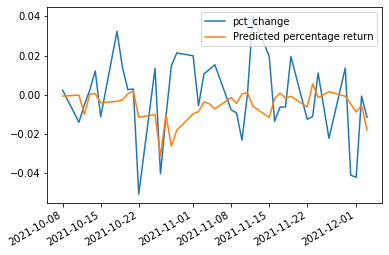

In [74]:
results.plot()

In [79]:
# Statistical analysis of model
mse = mean_squared_error(results["pct_change"], results["Predicted percentage return"])
rmse = np.sqrt(mse)
r2 = r2_score(results['pct_change'], results['Predicted percentage return'])
print(f"R2 score: {r2}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")
results.head(10)

R2 score: -0.10100297241594869
Out-of-Sample Root Mean Squared Error (RMSE): 0.020804915021891888


,pct_change,Predicted percentage return
2021-10-08,0.002369,-0.000624
2021-10-11,-0.013970,-0.000145
2021-10-12,-0.005040,-0.009906
2021-10-13,0.002440,0.000386
2021-10-14,0.012171,0.000546
2021-10-15,-0.011172,-0.003995
2021-10-18,0.032387,-0.003313
2021-10-19,0.014045,-0.002577
2021-10-20,0.002647,0.000577
2021-10-21,0.002992,0.001913


In [ ]:
# The End